In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations, save_model_GCN
from utils import get_device, plot_training_progress
from model import GCNNetwork

from args import *
from utils import *

/root/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

In [3]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()

in_dim = train_dataset[0].x.shape[-1]
model = GCNNetwork(in_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=args["sche_mode"], factor=args["sche_factor"], patience=args["sche_patience"], min_lr=args["sche_min_lr"])

25092 8364 8363


In [ ]:
train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

In [ ]:
epoch_start = None
epoch = epoch_start
epochs = args["epochs"]

test_best_loss = None
result_path = createResultFolder()

for epoch in range(epoch_start + 1, epochs + 1):

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    progress_msg = "Epoch " + str(epoch)
    progress_msg += ", train loss(MAE)=" + str(round(train_loss, 4))
    progress_msg += ", valid loss(MAE)=" + str(round(val_loss, 4))
    progress_msg += ", test loss(MAE)=" + str(round(test_loss, 4))
    progress_msg += ", lr=" + str(round(current_lr, 8))
    progress_msg += ", best_test=" + str(round(test_loss, 4))

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    print(progress_msg)
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=10)

    # save best model
    if test_best_loss is None or test_losses < test_best_loss:
        test_best_loss = test_losses
        save_model_GCN(epoch, model, optimizer, scheduler, result_path)

MAE loss of formation energy is:  0.24537140130996704


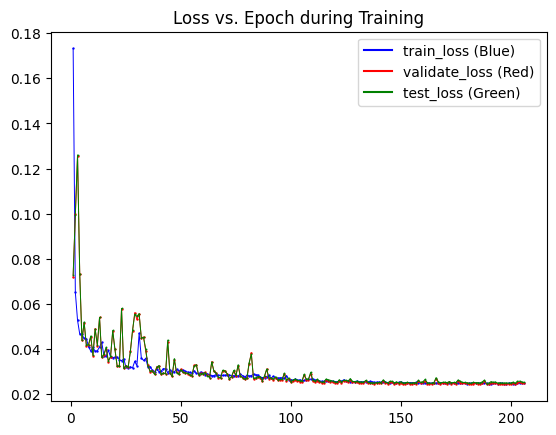

MAE=  0.24537138850598741


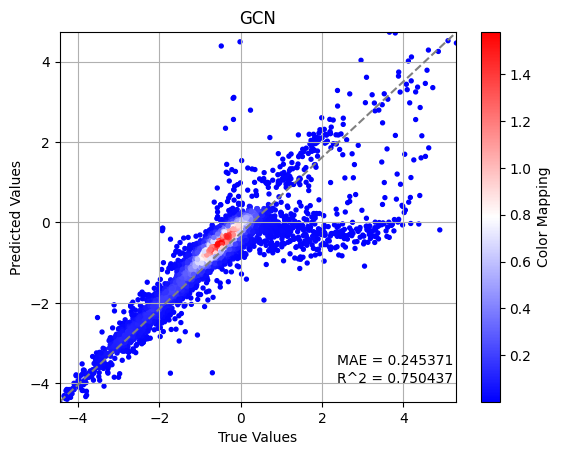

In [9]:
save_hyper_parameter(args, result_path)
save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

# Reverse normalization of test_out and y
min, max = get_data_scale(args)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print("MAE loss of formation energy is: ", loss.item())

# save results
plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path)
save_regression_result(test_out, test_y, result_path)
plot_regression_result("GCN", result_path, plotfilename="regression_figure.jpeg")